# Model Evaluations

In [1]:
import os

import e2cnn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import PIL

import seaborn as sns
import matplotlib as mpl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import configparser as ConfigParser

import utils
# Ipmport various network architectures
from networks import AGRadGalNet, DNSteerableLeNet, DNSteerableAGRadGalNet #e2cnn module only works in python3.7+
# Import various data classes
from datasets import FRDEEPF
from datasets import MiraBest_full, MBFRConfident, MBFRUncertain, MBHybrid
from datasets import MingoLoTSS, MLFR, MLFRTest

from sklearn.metrics import classification_report, roc_curve, auc

In [2]:
df = pd.read_csv('full_evaluations.csv')

df = df.sort_values('auc', ascending=False).drop(columns=['epoch', 'best'])
df[df.train_data==df.test_data].round(3).head(60)

,model,kernel_size,train_data,train_augmentation,test_data,test_augmentation,0 precision,0 recall,0 f1-score,0 support,1 precision,1 recall,1 f1-score,1 support,auc
0,DNSteerableLeNet,5,MLFR,random rotation,MLFR,random rotation,0.869,0.924,0.896,18000,0.749,0.619,0.678,6600,0.919
1,DNSteerableLeNet,5,MLFR,random rotation,MLFR,rotation and flipping,0.867,0.920,0.893,18000,0.738,0.616,0.671,6600,0.914
2,DNSteerableLeNet,5,MLFR,random rotation,MLFR,restricted random rotation,0.868,0.917,0.892,18000,0.731,0.619,0.670,6600,0.913
3,DNSteerableLeNet,5,MLFR,restricted random rotation,MLFR,rotation and flipping,0.867,0.909,0.887,18000,0.714,0.619,0.663,6600,0.900
4,DNSteerableLeNet,5,MLFR,restricted random rotation,MLFR,restricted random rotation,0.864,0.904,0.884,18000,0.701,0.613,0.654,6600,0.896
5,DNSteerableLeNet,5,MLFR,restricted random rotation,MLFR,random rotation,0.853,0.910,0.880,18000,0.699,0.572,0.629,6600,0.885
6,AGRadGalNet,3,MLFR,random rotation,MLFR,rotation and flipping,0.883,0.919,0.901,18000,0.751,0.669,0.708,6600,0.876
7,AGRadGalNet,3,MLFR,random rotation,MLFR,restricted random rotation,0.884,0.929,0.906,18000,0.774,0.668,0.717,6600,0.870
8,AGRadGalNet,3,MLFR,random rotation,MLFR,random rotation,0.883,0.930,0.906,18000,0.776,0.664,0.715,6600,0.867
9,DNSteerableLeNet,5,MLFR,rotation and flipping,MLFR,restricted random rotation,0.825,0.913,0.867,18000,0.666,0.471,0.552,6600,0.859


In [3]:
df[(df.model!='DNSteerableLeNet') & (df.train_data=='MLFR') & (df.test_data==df.train_data) & (df.train_augmentation=='random rotation')]

,model,kernel_size,train_data,train_augmentation,test_data,test_augmentation,0 precision,0 recall,0 f1-score,0 support,1 precision,1 recall,1 f1-score,1 support,auc
6,AGRadGalNet,3,MLFR,random rotation,MLFR,rotation and flipping,0.883245,0.918722,0.900634,18000,0.751063,0.668788,0.707542,6600,0.875690
7,AGRadGalNet,3,MLFR,random rotation,MLFR,restricted random rotation,0.884152,0.928556,0.905810,18000,0.774228,0.668182,0.717306,6600,0.870138
8,AGRadGalNet,3,MLFR,random rotation,MLFR,random rotation,0.882874,0.929667,0.905667,18000,0.775770,0.663636,0.715336,6600,0.867108
108,DNSteerableAGRadGalNet,5,MLFR,random rotation,MLFR,rotation and flipping,0.805805,0.948611,0.871396,18000,0.728739,0.376515,0.496503,6600,0.700617
110,DNSteerableAGRadGalNet,5,MLFR,random rotation,MLFR,restricted random rotation,0.805569,0.946722,0.870460,18000,0.721706,0.376818,0.495122,6600,0.695301
109,DNSteerableAGRadGalNet,5,MLFR,random rotation,MLFR,random rotation,0.803936,0.941722,0.867392,18000,0.701565,0.373636,0.487593,6600,0.689991
21,DNSteerableAGRadGalNet,3,MLFR,random rotation,MLFR,random rotation,0.813129,0.893944,0.851623,18000,0.603201,0.439697,0.508632,6600,0.688906
22,DNSteerableAGRadGalNet,3,MLFR,random rotation,MLFR,restricted random rotation,0.811807,0.898444,0.852931,18000,0.609318,0.431970,0.505541,6600,0.687974
24,DNSteerableAGRadGalNet,3,MLFR,random rotation,MLFR,rotation and flipping,0.810468,0.904167,0.854757,18000,0.618278,0.423333,0.502563,6600,0.679966
111,DNSteerableAGRadGalNet,7,MLFR,random rotation,MLFR,rotation and flipping,0.776431,0.928611,0.845730,18000,0.581706,0.270758,0.369520,6600,0.607614


In [4]:
pd.pivot_table(
    df[(df.test_data==df.train_data) & (df.test_augmentation=='random rotation')],
    values=['auc', '0 f1-score', '1 f1-score'],
    index=[],
    columns=["model", "train_data", "train_augmentation", "test_data"],
    #aggfunc=np.mean
)


model                  AGRadGalNet                             \
train_data           MBFRUncertain                              
train_augmentation random rotation restricted random rotation   
test_data            MBFRUncertain              MBFRUncertain   
0 f1-score                0.608639                   0.683580   
1 f1-score                0.652802                   0.578634   
auc                       0.662274                   0.643103   

model                                                     \
train_data                                          MLFR   
train_augmentation rotation and flipping random rotation   
test_data                  MBFRUncertain            MLFR   
0 f1-score                      0.700228        0.905667   
1 f1-score                      0.497542        0.715336   
auc                             0.636849        0.867108   

model                                                                \
train_data                                                            
train_augmentation restricted random rotation rotation and flipping   
test_data                                MLFR                  MLFR   
0 f1-score                           0.907343              0.912313   
1 f1-score                           0.697416              0.720116   
auc                                  0.839465              0.847404   

model              DNSteerableAGRadGalNet                             \
train_data                  MBFRUncertain                              
train_augmentation        random rotation restricted random rotation   
test_data                   MBFRUncertain              MBFRUncertain   
0 f1-score                       0.318406                   0.393520   
1 f1-score                       0.631757                   0.611418   
auc                              0.583860                   0.548036   

model                                                     \
train_data                                          MLFR   
train_augmentation rotation and flipping random rotation   
test_data                  MBFRUncertain            MLFR   
0 f1-score                      0.413180        0.856152   
1 f1-score                      0.624498        0.457879   
auc                             0.562904        0.662010   

model                                                                \
train_data                                                            
train_augmentation restricted random rotation rotation and flipping   
test_data                                MLFR                  MLFR   
0 f1-score                           0.847335              0.874521   
1 f1-score                           0.400801              0.494944   
auc                                  0.624358              0.687815   

model              DNSteerableLeNet                             \
train_data            MBFRUncertain                              
train_augmentation  random rotation restricted random rotation   
test_data             MBFRUncertain              MBFRUncertain   
0 f1-score                 0.560999                   0.601889   
1 f1-score                 0.519136                   0.552352   
auc                        0.613679                   0.600982   

model                                                     \
train_data                                          MLFR   
train_augmentation rotation and flipping random rotation   
test_data                  MBFRUncertain            MLFR   
0 f1-score                      0.594101        0.895529   
1 f1-score                      0.530693        0.677952   
auc                             0.589153        0.918539   

model                                                                
train_data                                                           
train_augmentation restricted random rotation rotation and flipping  
test_data                                MLFR                  MLFR  
0 f1-score                           

MiraBest


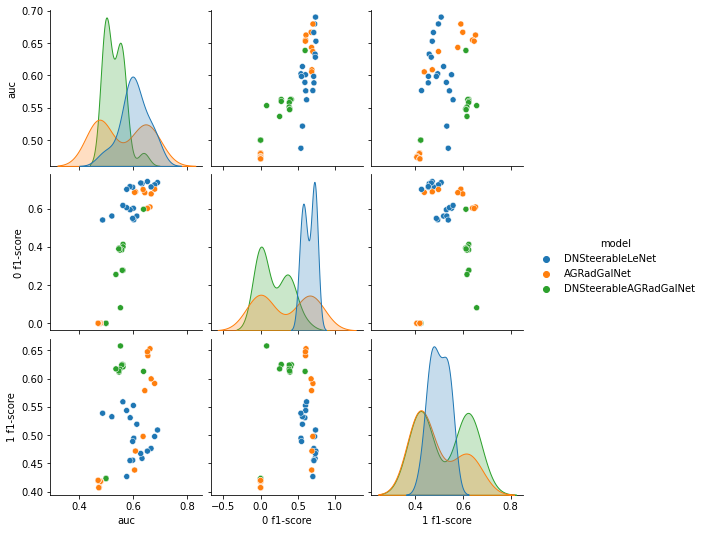

In [5]:
# MiraBest
print("MiraBest")
g = sns.pairplot(
    df[df.train_data=='MBFRUncertain'][['auc','0 f1-score', '1 f1-score', 'model']], 
    hue="model"
)
plt.show(g)

Mingo LoTSS


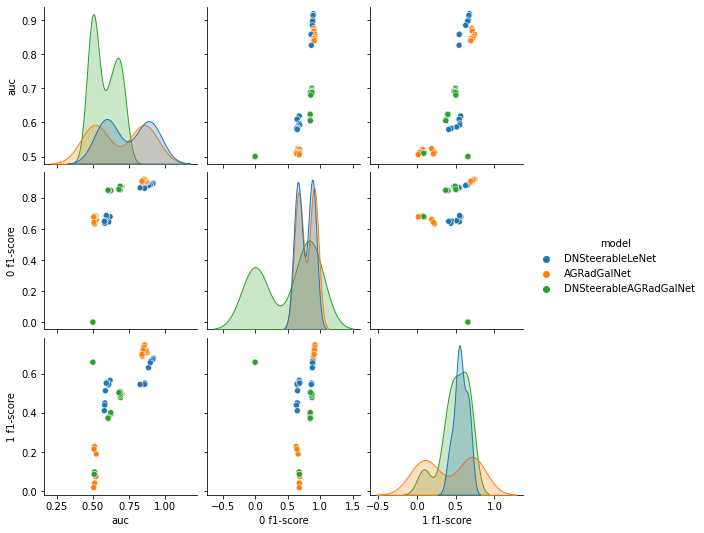

In [6]:
# MLFR
print("Mingo LoTSS")
g = sns.pairplot(
    df[df.train_data=='MLFR'][['auc','0 f1-score', '1 f1-score', 'model']], 
    hue="model"
)
plt.show(g)

Mingo LoTSS


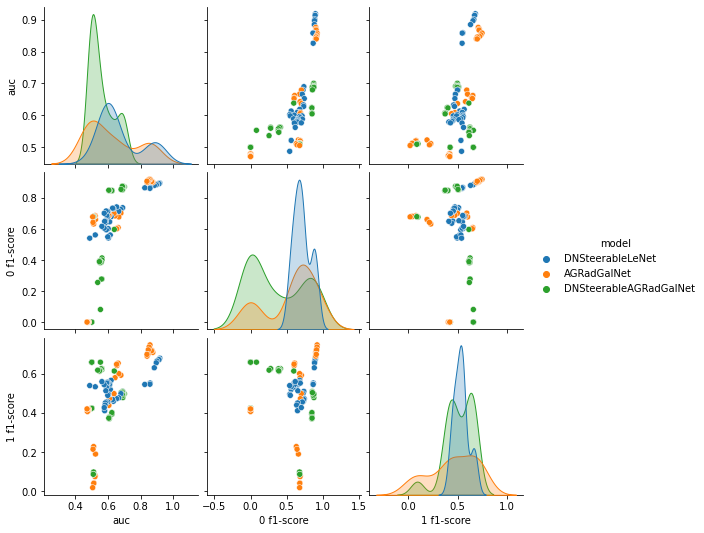

In [7]:
# MLFR
print("Mingo LoTSS")
g = sns.pairplot(
    df[['auc','0 f1-score', '1 f1-score', 'model']], 
    hue="model"
)
plt.show(g)

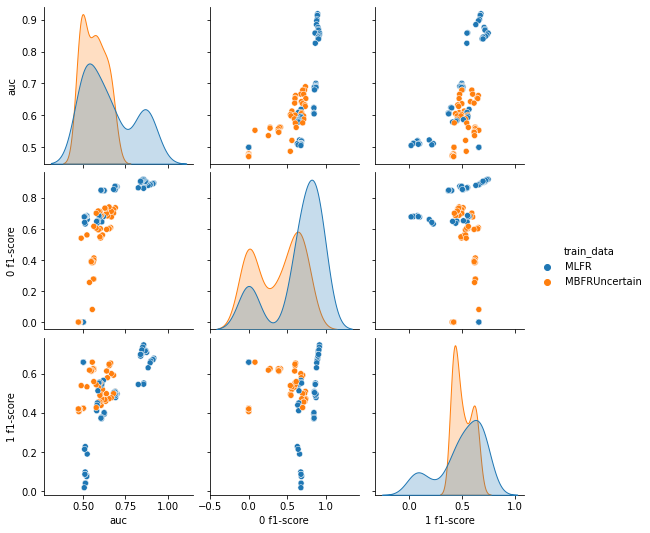

In [8]:
sns.pairplot(
    df[['auc','0 f1-score', '1 f1-score', 'train_data']], 
    hue="train_data"
)

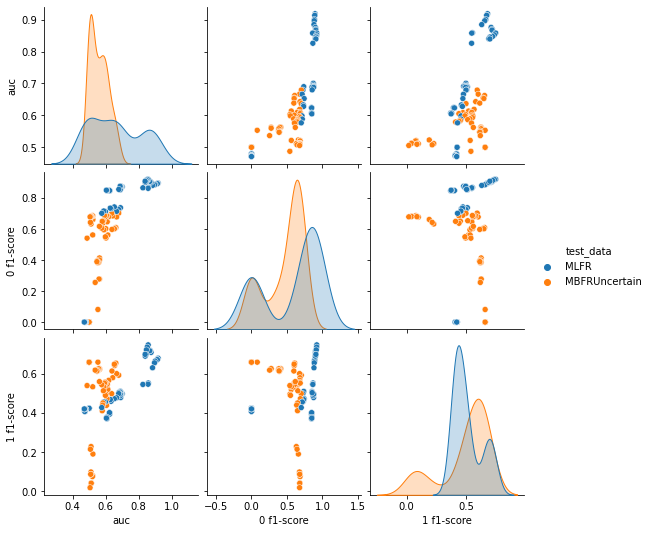

In [9]:
sns.pairplot(
    df[['auc','0 f1-score', '1 f1-score', 'test_data']], 
    hue="test_data"
)

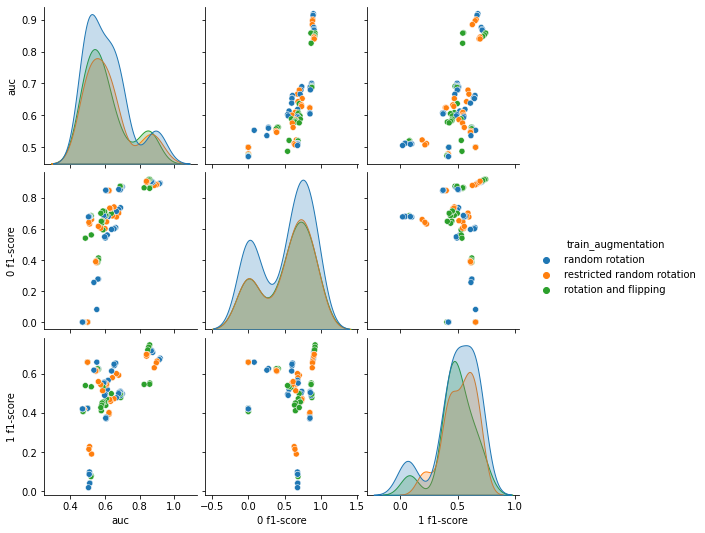

In [10]:
sns.pairplot(
    df[['auc','0 f1-score', '1 f1-score', 'train_augmentation']], 
    hue="train_augmentation"
)

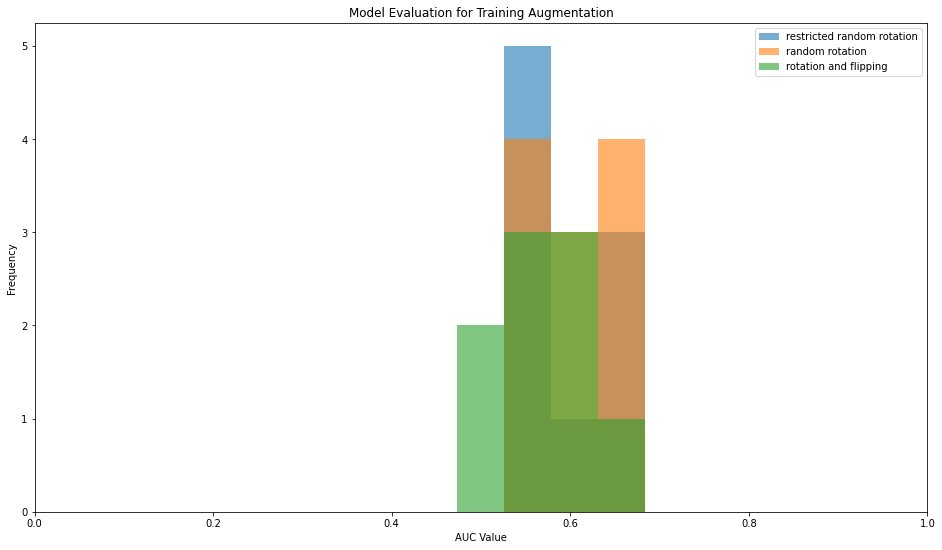

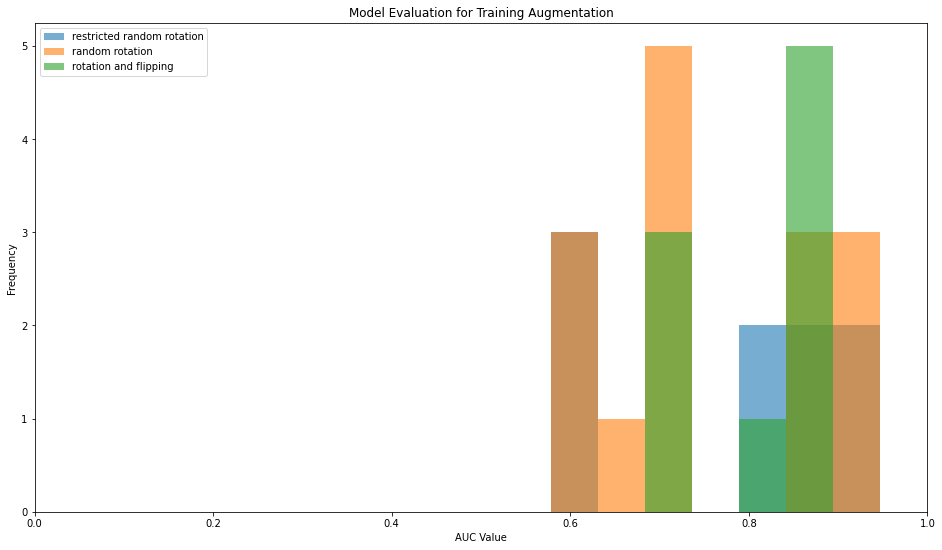

In [11]:
# Hist according to train / eval data (transfer learning)
plt.figure(figsize=(16,9))
#df[df.train_data==df.test_data][['auc']].plot.hist(20)
bins = np.linspace(0, 1, 20)
for data in ['MBFRUncertain']:
    for augment in ['restricted random rotation', 'random rotation', 'rotation and flipping']:
        df[(df.train_data==df.test_data) & (df.train_augmentation==augment) & (df.train_data==data)]['auc'].plot.hist(bins=bins, label=f'{augment}',  histtype='bar', stacked=True, alpha=0.6)

plt.xlim((0,1))
plt.xlabel('AUC Value')
plt.title('Model Evaluation for Training Augmentation')
plt.legend()
plt.show()

plt.figure(figsize=(16,9))
#df[df.train_data==df.test_data][['auc']].plot.hist(20)
bins = np.linspace(0, 1, 20)
for data in ['MLFR']:
    for augment in ['restricted random rotation', 'random rotation', 'rotation and flipping']:
        df[(df.train_data==df.test_data) & (df.train_augmentation==augment) & (df.train_data==data)]['auc'].plot.hist(bins=bins, label=f'{augment}',  histtype='bar', stacked=True, alpha=0.6)

plt.xlim((0,1))
plt.xlabel('AUC Value')
plt.title('Model Evaluation for Training Augmentation')
plt.legend()
plt.show()


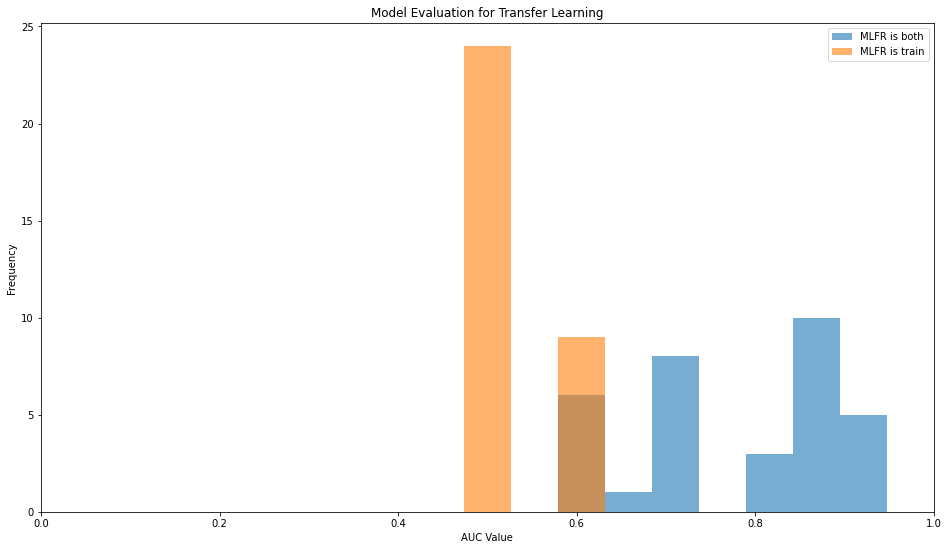

In [12]:
# Hist according to train / eval data (transfer learning)
plt.figure(figsize=(16,9))
bins = np.linspace(0, 1, 20)
for idx, data_name in enumerate(['MLFR', 'MBFRUncertain']):
    df[(df.train_data==df.test_data) & (df.train_data==data_name)]['auc'].plot.hist(bins=bins, label=f'{data_name} is both',  histtype='stepfilled', alpha=0.6)
    df[(df.train_data!=df.test_data) & (df.train_data==data_name)]['auc'].plot.hist(bins=bins, label=f'{data_name} is train', histtype='stepfilled', alpha=0.6)
    break
plt.xlim((0,1))
plt.xlabel('AUC Value')
plt.title('Model Evaluation for Transfer Learning')
plt.legend()

plt.show()

## To visualise / plot:
- [x] Mean across train_data
- [x] Mean across train_augmentation
- [x] Mean across model

### Mean across train_augmentation

In [13]:
df.groupby(by=['train_augmentation']).mean().round(2)

,kernel_size,0 precision,0 recall,0 f1-score,0 support,1 precision,1 recall,1 f1-score,1 support,auc
train_augmentation,,,,,,,,,,
random rotation,4.38,0.51,0.55,0.51,10250.0,0.57,0.62,0.49,4500.0,0.61
restricted random rotation,3.67,0.52,0.56,0.53,10250.0,0.53,0.62,0.52,4500.0,0.62
rotation and flipping,3.67,0.51,0.58,0.53,10250.0,0.58,0.59,0.49,4500.0,0.61


In [14]:
df.groupby(by=['train_augmentation']).var().round(2)

,kernel_size,0 precision,0 recall,0 f1-score,0 support,1 precision,1 recall,1 f1-score,1 support,auc
train_augmentation,,,,,,,,,,
random rotation,2.12,0.11,0.16,0.13,61240196.08,0.04,0.10,0.03,4496470.59,0.02
restricted random rotation,0.91,0.10,0.14,0.11,61778571.43,0.03,0.07,0.02,4536000.00,0.02
rotation and flipping,0.91,0.10,0.15,0.11,61778571.43,0.05,0.09,0.03,4536000.00,0.02


In [15]:
df.groupby(by=['train_augmentation']).count()

,model,kernel_size,train_data,test_data,test_augmentation,0 precision,0 recall,0 f1-score,0 support,1 precision,1 recall,1 f1-score,1 support,auc
train_augmentation,,,,,,,,,,,,,,
random rotation,52,52,52,52,52,52,52,52,52,52,52,52,52,52
restricted random rotation,36,36,36,36,36,36,36,36,36,36,36,36,36,36
rotation and flipping,36,36,36,36,36,36,36,36,36,36,36,36,36,36


### Mean across train_data

In [16]:
df.groupby(by=['train_data']).mean().round(2)

,kernel_size,0 precision,0 recall,0 f1-score,0 support,1 precision,1 recall,1 f1-score,1 support,auc
train_data,,,,,,,,,,
MBFRUncertain,3.83,0.42,0.36,0.37,10250.0,0.44,0.75,0.51,4500.0,0.56
MLFR,4.09,0.59,0.74,0.65,10250.0,0.68,0.50,0.49,4500.0,0.65


In [17]:
df.groupby(by=['train_data']).var().round(2)

,kernel_size,0 precision,0 recall,0 f1-score,0 support,1 precision,1 recall,1 f1-score,1 support,auc
train_data,,,,,,,,,,
MBFRUncertain,1.27,0.1,0.10,0.09,61116228.07,0.02,0.05,0.01,4487368.42,0.00
MLFR,1.75,0.1,0.13,0.10,60986538.46,0.02,0.09,0.04,4477846.15,0.02


In [18]:
df.groupby(by=['train_data']).count()

,model,kernel_size,train_augmentation,test_data,test_augmentation,0 precision,0 recall,0 f1-score,0 support,1 precision,1 recall,1 f1-score,1 support,auc
train_data,,,,,,,,,,,,,,
MBFRUncertain,58,58,58,58,58,58,58,58,58,58,58,58,58,58
MLFR,66,66,66,66,66,66,66,66,66,66,66,66,66,66


### Mean across model

In [19]:
df.groupby(by=['model']).mean().round(2)

,kernel_size,0 precision,0 recall,0 f1-score,0 support,1 precision,1 recall,1 f1-score,1 support,auc
model,,,,,,,,,,
AGRadGalNet,3.00,0.51,0.66,0.56,10250.0,0.64,0.55,0.45,4500.0,0.62
DNSteerableAGRadGalNet,3.92,0.38,0.38,0.36,10250.0,0.51,0.71,0.51,4500.0,0.56
DNSteerableLeNet,5.00,0.70,0.73,0.71,10250.0,0.57,0.53,0.53,4500.0,0.67


In [20]:
df.groupby(by=['model']).var().round(2)

,kernel_size,0 precision,0 recall,0 f1-score,0 support,1 precision,1 recall,1 f1-score,1 support,auc
model,,,,,,,,,,
AGRadGalNet,0.00,0.10,0.16,0.12,61778571.43,0.07,0.12,0.05,4536000.00,0.02
DNSteerableAGRadGalNet,2.27,0.13,0.18,0.14,61240196.08,0.02,0.11,0.02,4496470.59,0.01
DNSteerableLeNet,0.00,0.02,0.02,0.01,61778571.43,0.01,0.01,0.01,4536000.00,0.02


In [21]:
df.groupby(by=['model']).count()

,kernel_size,train_data,train_augmentation,test_data,test_augmentation,0 precision,0 recall,0 f1-score,0 support,1 precision,1 recall,1 f1-score,1 support,auc
model,,,,,,,,,,,,,,
AGRadGalNet,36,36,36,36,36,36,36,36,36,36,36,36,36,36
DNSteerableAGRadGalNet,52,52,52,52,52,52,52,52,52,52,52,52,52,52
DNSteerableLeNet,36,36,36,36,36,36,36,36,36,36,36,36,36,36
